In [1]:
# Nos conectamos a nuestro conjunto de datos

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import metrics 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# optimizador de la red por medio de Bayessian Optimization
from bayes_opt import BayesianOptimization


In [2]:
# Check tensorflow version
print(tf.__version__)

2.9.2


In [3]:
# Abrimos nuestros dataset para prepararlo
df_train = pd.read_csv('train_data.csv', sep=';', decimal='.')
print(df_train.shape)

df_test = pd.read_csv('test_data.csv', sep=';', decimal='.')
print(df_test.shape)

(750, 22)
(250, 22)


In [4]:
# Separamos x_train, y_train y convertimos a numpy
x_train = df_train.drop('Price', axis=1).values
y_train = df_train['Price'].values

# Hacemos lo mismo con el conjunto de test
x_test = df_test.drop('Price', axis=1).values
y_test = df_test['Price'].values


In [5]:
# Normalizamos los datos
#scaler = StandardScaler()
##x_train = scaler.fit_transform(x_train)
##x_test = scaler.transform(x_test)

#scaler.fit(x_train)
# Transform the training and validation data
#x_train = scaler.transform(x_train)
#x_test = scaler.transform(x_test)

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Create the scaler object
scaler = MinMaxScaler()

# Fit the scaler to the training data
scaler.fit(x_train)

# Transform the training and test data
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [7]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [8]:
# Revisamos que no tengamos valores negativos
# Find the minimum value in each column
min_vals = np.min(x_tr, axis=0)

# Print the minimum value in each column
print('Minimum values in each column:')
for i, val in enumerate(min_vals):
    print(f'Column {i+1}: {val}')

Minimum values in each column:
Column 1: 0.0
Column 2: 0.0
Column 3: 0.0
Column 4: 0.0
Column 5: 0.0
Column 6: 0.0
Column 7: 0.0
Column 8: 0.0
Column 9: 0.0
Column 10: 0.0
Column 11: 0.0
Column 12: 0.0
Column 13: 0.0
Column 14: 0.0
Column 15: 0.0
Column 16: 0.0
Column 17: 0.0
Column 18: 0.0
Column 19: 0.0
Column 20: 0.0
Column 21: 0.0


In [15]:
import locale
from matplotlib import image as mpimg
import matplotlib.gridspec as gridspec
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model

# definimos la función para entrenar nuestra red con los parámetros deseados
def train_deep_net(activation_function, learning_rate, lr_decay, batch_size, num_epochs, min_lr, patiente):
  
  # Implementamos la red empleando Keras
  model = Sequential() # Instancia de modelo API secuencial #(X)
  model.add(Dense(64, activation=activation_function, input_shape=(x_tr.shape[1],)))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation=activation_function))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation=activation_function))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation=activation_function))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation=activation_function))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='linear'))

  # Hacemos plot de la estructura de la red
  #model.summary()
  plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

  # Create the callbacks
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=patiente, min_lr=min_lr)

  # Compilamos el modelo
  model.compile(
      optimizer=Adam(learning_rate=learning_rate, decay=lr_decay), 
      loss='mse', 
      metrics=[metrics.MeanAbsoluteError(), metrics.MeanSquaredError(), metrics.RootMeanSquaredError(), metrics.Accuracy()]
      ) #(X)
  # Entrenamos el modelo
  H = model.fit(x_tr, y_tr, 
                batch_size=batch_size, 
                epochs=num_epochs, 
                validation_data=(x_val, y_val), 
                callbacks=[early_stopping, reduce_lr], 
                verbose=0)
  # print(H.history)
  # Save history
    with open('history.txt', 'w') as f:
        f.write(str(H.history))

  # Evaluamos con test
  y_pred = model.predict(x_test, batch_size=batch_size)

  # Evaluate the performance of the model
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  # Print the evaluation metrics
  print('Mean Squared Error (MSE):', mse)
  print('Mean Absolute Error (MAE):', mae)
  print('R-squared (R^2):', r2)

  # compute the difference between the *predicted* house prices and the
  # *actual* house prices, then compute the percentage difference and
  # the absolute percentage difference
  diff = y_pred.flatten() - y_test
  percentDiff = (diff / y_test) * 100
  absPercentDiff = np.abs(percentDiff)
  # compute the mean and standard deviation of the absolute percentage
  # difference
  mean = np.mean(absPercentDiff)
  std = np.std(absPercentDiff)
  # finally, show some statistics on our model
  locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
  print("[INFO] avg. house price: {}, std house price: {}".format(
      locale.currency(df_train["Price"].mean(), grouping=True),
      locale.currency(df_train["Price"].std(), grouping=True)))
  print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

  # Create a grid of subplots that shares the y-axis across rows and the x-axis across columns
  fig = plt.figure(figsize=(12, 10))
  gs = gridspec.GridSpec(nrows=2, ncols=2, figure=fig, hspace=0.5, wspace=0.2, height_ratios=[1, 1])

  # Plot the training and validation curves for each metric
  for i, metric in enumerate(['mean_absolute_error', 'mean_squared_error', 'root_mean_squared_error']):
      row = i // 2
      col = i % 2
      ax = fig.add_subplot(gs[row, col])
      ax.plot(H.history[metric], label='Training')
      ax.plot(H.history['val_' + metric], label='Validation')
      ax.set_title(metric)
      ax.set_xlabel('Epoch')
      ax.set_ylabel(metric)
      ax.legend(loc='upper right')

  # Add a subplot to show the accuracy over time
  # ax = fig.add_subplot(gs[1, 1])
  # ax.plot(H.history['accuracy'], label='Training')
  # ax.plot(H.history['val_accuracy'], label='Validation')
  # ax.set_title('Accuracy')
  # ax.set_xlabel('Epoch')
  # ax.set_ylabel('Accuracy')
  # ax.legend(loc='upper right')
  
  # Add a horizontal line to the plot for the R2 score
  #plt.axhline(y=r2, color='k', linestyle='--', label='R2 score')
  #plt.suptitle('Training and Validation Metrics', fontsize=16, y=1.05)
  #plt.legend(loc='lower right')
  plt.show()



In [11]:
# Ahora vamos a buscar el numero idoneo de neuronas y de capas

# Define the function to optimize
def optimize_network(num_layers, num_neurons, learning_rate, decay, min_lr, patience):
    # Create the model with the given hyperparameters
    model = Sequential()
    model.add(Dense(num_neurons, activation='relu', input_shape=(x_train.shape[1],)))
    for i in range(int(num_layers)):
        model.add(Dense(num_neurons, activation='relu'))
        model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=learning_rate, decay=decay), loss='mse')
    callbacks = [
        EarlyStopping(patience=patience, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=patience // 2, min_lr=min_lr)
    ]

    # Train the model and return the validation loss
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=300, batch_size=128, callbacks= callbacks, verbose=0)
    val_loss = history.history['val_loss'][-1]
    return -val_loss

# Define the hyperparameter search space
pbounds = {'num_layers': (1, 5), 'num_neurons': (32, 128), 'learning_rate': (1e-7, 1e-1), 'decay': (1e-7, 1e-1), 'min_lr': (1e-6, 1e-1), 'patience': (3, 15)}

# Create the optimizer and run the search
optimizer = BayesianOptimization(f=optimize_network, pbounds=pbounds)
optimizer.maximize(n_iter=20)

# Print the best hyperparameters found
print(optimizer.max)



|   iter    |  target   |   decay   | learni... |  min_lr   | num_la... | num_ne... | patience  |
-------------------------------------------------------------------------------------------------
| 1         | -642.3    | 0.08984   | 0.04131   | 0.002111  | 4.801     | 82.01     | 5.833     |
| 2         | -261.1    | 0.01302   | 0.0299    | 0.02018   | 3.922     | 82.71     | 6.159     |
| 3         | -496.2    | 0.06788   | 0.07883   | 0.06781   | 4.538     | 55.75     | 12.52     |
| 4         | -329.7    | 0.004626  | 0.08637   | 0.05561   | 1.524     | 61.46     | 4.889     |
| 5         | -427.8    | 0.03654   | 0.09631   | 0.0009134 | 4.686     | 35.84     | 10.09     |
| 6         | -349.0    | 0.07412   | 0.02796   | 0.074     | 3.859     | 82.83     | 6.415     |
| 7         | -638.8    | 0.07114   | 0.002597  | 0.05951   | 2.029     | 75.6      | 8.369     |
| 8         | -392.8    | 0.09593   | 0.02884   | 0.04075   | 2.569     | 117.1     | 11.48     |
| 9         | -488.1

Entrenando con relu, 0.009, 0.007, 64
4/4 [==============================] - 0s 5ms/step
Mean Squared Error (MSE): 504.3652843037229
Mean Absolute Error (MAE): 13.527773094177245
R-squared (R^2): 0.6901054809138221
[INFO] avg. house price: $64.59, std house price: $55.36
[INFO] mean: 24.49%, std: 23.00%


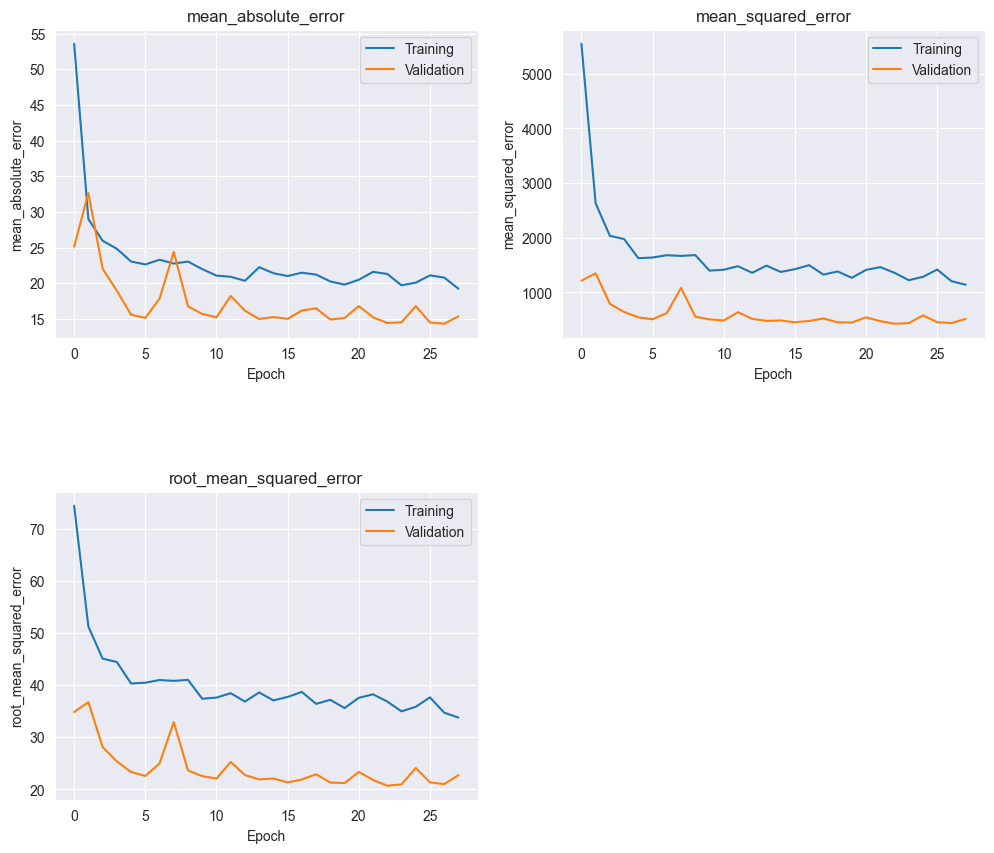

In [20]:
# Definimos los parámetros que queremos probar
activation_functions = ['relu']
learning_rates = [0.009] #[0.019] #[0.0033] # [1e-3 ]
lr_decays = [0.007] #[0.007] #[0.00033] # [1e-3 / 200]
batch_sizes = [64]
num_epochs = 300
min_lr = 0.007
patiente = 13 # 7
# llama a la función para entrenar la red con los parámetros deseados
results = {}
for activation_function in activation_functions:
    for learning_rate in learning_rates:
        for lr_decay in lr_decays:
            for batch_size in batch_sizes:
                print(f'Entrenando con {activation_function}, {learning_rate}, {lr_decay}, {batch_size}')
                train_deep_net(activation_function, learning_rate, lr_decay, batch_size, num_epochs, min_lr, patiente)